In [1]:
import pandas as pd
import numpy as np
import json
import sys

In [2]:
sys.path.append('../scripts/')
import utils

## adding z coords to geojson pts

In [2]:
#with open('../gis/gurla_z_pts.geojson') as f:
#    gp = json.load(f)

In [3]:
#for feat in gp['features']:
#    coords = feat['geometry']['coordinates']
#    z_val = feat['properties']['Z']
#    coords.append(z_val)

In [4]:
#with open('../gis/gurla_z_pts.geojson', 'w') as f:
#    json.dump(gp, f)

In [5]:
#gp['features'][0]

## adding z coords to geojson polys

### make pt table

In [3]:
pdf = pd.read_csv('../data/gis/gurla_z_pts.csv', index_col=3)

pdf.head()

,X,Y,Z
id,,,
0,-48162.772008,3350150.791763,3685
1,-50157.176651,3351825.986467,3681
2,-51194.059027,3354386.865733,3841
3,-53080.208694,3356174.076748,3948
4,-54299.894490,3358102.938650,4118


### get geojson tris

In [4]:
with open('../data/fault_data/gurla_tris.geojson') as f:
    gt = json.load(f)

### get z values

In [5]:
gt['features'][0]['geometry']['coordinates']#[0][0]

[[[-55783.583006836, 3342716.71580536, -14985.0],
  [-54677.8965490291, 3339938.7432105276, -19768.0],
  [-56725.8969340146, 3341331.705430983, -19747.0],
  [-55783.583006836, 3342716.71580536, -14985.0]]]

In [8]:
gc = gt.copy()

In [8]:
for feat in gc['features']:
    coors = feat['geometry']['coordinates'][0]
    zs = pdf.loc[(int(feat['properties']['POINTA']), int(feat['properties']['POINTB']), 
                  int(feat['properties']['POINTC']), int(feat['properties']['POINTA'])), 'Z'
                 ].values
    for i, coor in enumerate(coors):
        #coor.append(float(zs[i]))  # only do this the first time
        pass

In [9]:
gc['features'][-1]

{'geometry': {'coordinates': [[[-57886.2658870933,
     3407087.5218043914,
     -20455.0],
    [-54899.2065167453, 3407362.546040953, -20455.0],
    [-55140.9567051379, 3405082.4065878605, -15455.0],
    [-57886.2658870933, 3407087.5218043914, -20455.0]]],
  'type': 'Polygon'},
 'properties': {'POINTA': 175.0,
  'POINTB': 174.0,
  'POINTC': 142.0,
  'area_sq_km': 8.222550024690099,
  'center': [-55975.476369658834, 3406510.824811069, -18788.333333333332],
  'dip': 65.7877783239506,
  'rake': -5.306359459150454,
  'rake_err': 10,
  'strike': 264.7395000005746},
 'type': 'Feature'}

### get centers and area

$S = \frac{|AB \times AC|}{2}$

In [12]:
def area(coords):
    ab = np.array(coords[0]) - np.array(coords[1])
    ac = np.array(coords[0]) - np.array(coords[2])
    
    return np.linalg.norm(np.cross(ab, ac)) / 2e6

In [13]:
def center(coords):
    return ((np.array(coords[0]) + np.array(coords[1]) 
             + np.array(coords[2])) / 3).tolist()

center(coors)

[-55975.476369658834, 3406510.824811069, -18788.333333333332]

In [14]:
for feat in gc['features']:
    coords = feat['geometry']['coordinates'][0]
    feat['properties']['area_sq_km'] = area(coords)
    
    feat['properties']['center'] = center(coords)

In [15]:
gc['features'][100]

{'geometry': {'coordinates': [[[-63078.7116583341, 3368647.63774455, -816.0],
    [-56488.0645559977, 3367841.8357556644, 4045.0],
    [-56808.9791004168, 3366516.191889601, 4263.0],
    [-63078.7116583341, 3368647.63774455, -816.0]]],
  'type': 'Polygon'},
 'properties': {'POINTA': 36.0,
  'POINTB': 9.0,
  'POINTC': 8.0,
  'area_sq_km': 5.6830856866119914,
  'center': [-58791.91843824953, 3367668.5551299383, 2497.3333333333335]},
 'type': 'Feature'}

### get strike and dip

In [6]:
import halfspace.projections as hsp

In [9]:
for feat in gc['features']:
    coords = feat['geometry']['coordinates'][0]
    
    coo = [[co[0], co[1], co[2]] for co in coords[:-1]]
    
    s, d = hsp.strike_dip_from_3_xyz(coo[0], coo[1], coo[2])
    
    feat['properties']['strike'], feat['properties']['dip'] = s, d

In [10]:
gc['features'][100]

{'geometry': {'coordinates': [[[-63078.7116583341, 3368647.63774455, -816.0],
    [-56488.0645559977, 3367841.8357556644, 4045.0],
    [-56808.9791004168, 3366516.191889601, 4263.0],
    [-63078.7116583341, 3368647.63774455, -816.0]]],
  'type': 'Polygon'},
 'properties': {'POINTA': 36.0,
  'POINTB': 9.0,
  'POINTC': 8.0,
  'area_sq_km': 5.683085686611991,
  'center': [-58791.91843824953, 3367668.5551299383, 2497.3333333333335],
  'dip': 37.68134833327008,
  'rake': -67.6178881165946,
  'rake_err': 10,
  'strike': 205.55140107662217},
 'type': 'Feature'}

In [11]:
strikes = [feat['properties']['strike'] for feat in gc['features']]

### get rake

In [12]:
utils.add_strike_dip(gc['features'])
utils.add_rake_from_trend(gc['features'], 277.5, 10)

In [13]:
strikes = [feat['properties']['strike'] for feat in gc['features']]
dips = [feat['properties']['dip'] for feat in gc['features']]
rakes = [feat['properties']['rake'] for feat in gc['features']]
cx = [feat['properties']['center'][0] for feat in gc['features']]
cy = [feat['properties']['center'][1] for feat in gc['features']]
cz = [feat['properties']['center'][2] for feat in gc['features']]

In [14]:
def trend_from_sd_rake(strike=0., dip=0., rake=0., angle='degrees', 
                       aki_richards=False):
    
    if angle == 'degrees':
        strike = np.radians(strike)
        dip = np.radians(dip)
        rake = np.radians(rake)
    
    trend = -1 * (np.arctan( np.cos(dip) * np.tan(rake)) ) + strike
    
    if aki_richards == True:
        
        if np.isscalar(trend):
            if rake > np.pi/2:
                trend -= np.pi
            elif rake < - np.pi/2:
                trend += np.pi
        else:
            trend[rake > np.pi/2] -= np.pi
            trend[rake < -np.pi/2] += np.pi

    if angle == 'degrees':
        trend = np.degrees(trend)# + 180
        trend = hsp.unwrap_angle(trend)

    return trend

In [15]:
trends = trend_from_sd_rake(strikes, dips, rakes, aki_richards=True)

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

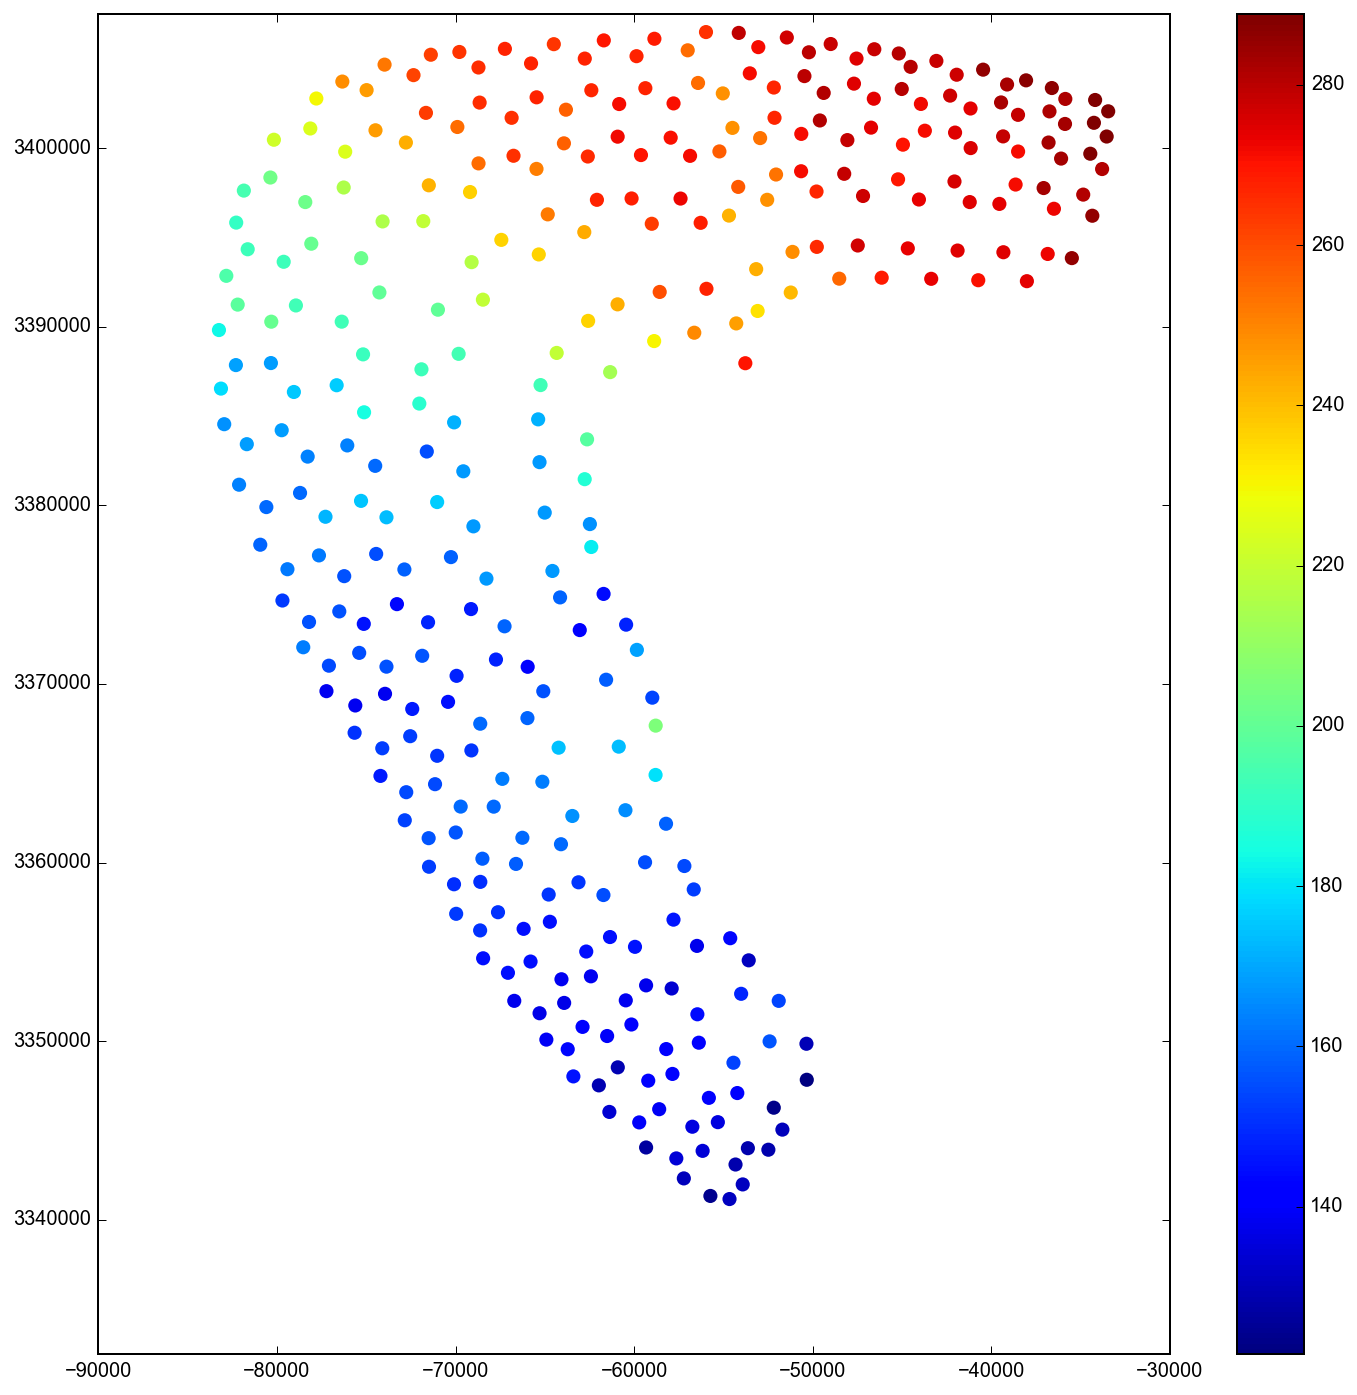

In [17]:
plt.figure(figsize=(12, 12))

plt.scatter(cx, cy, c=strikes,
           s=50, lw=0)
plt.colorbar()
plt.axis('equal')

plt.show()

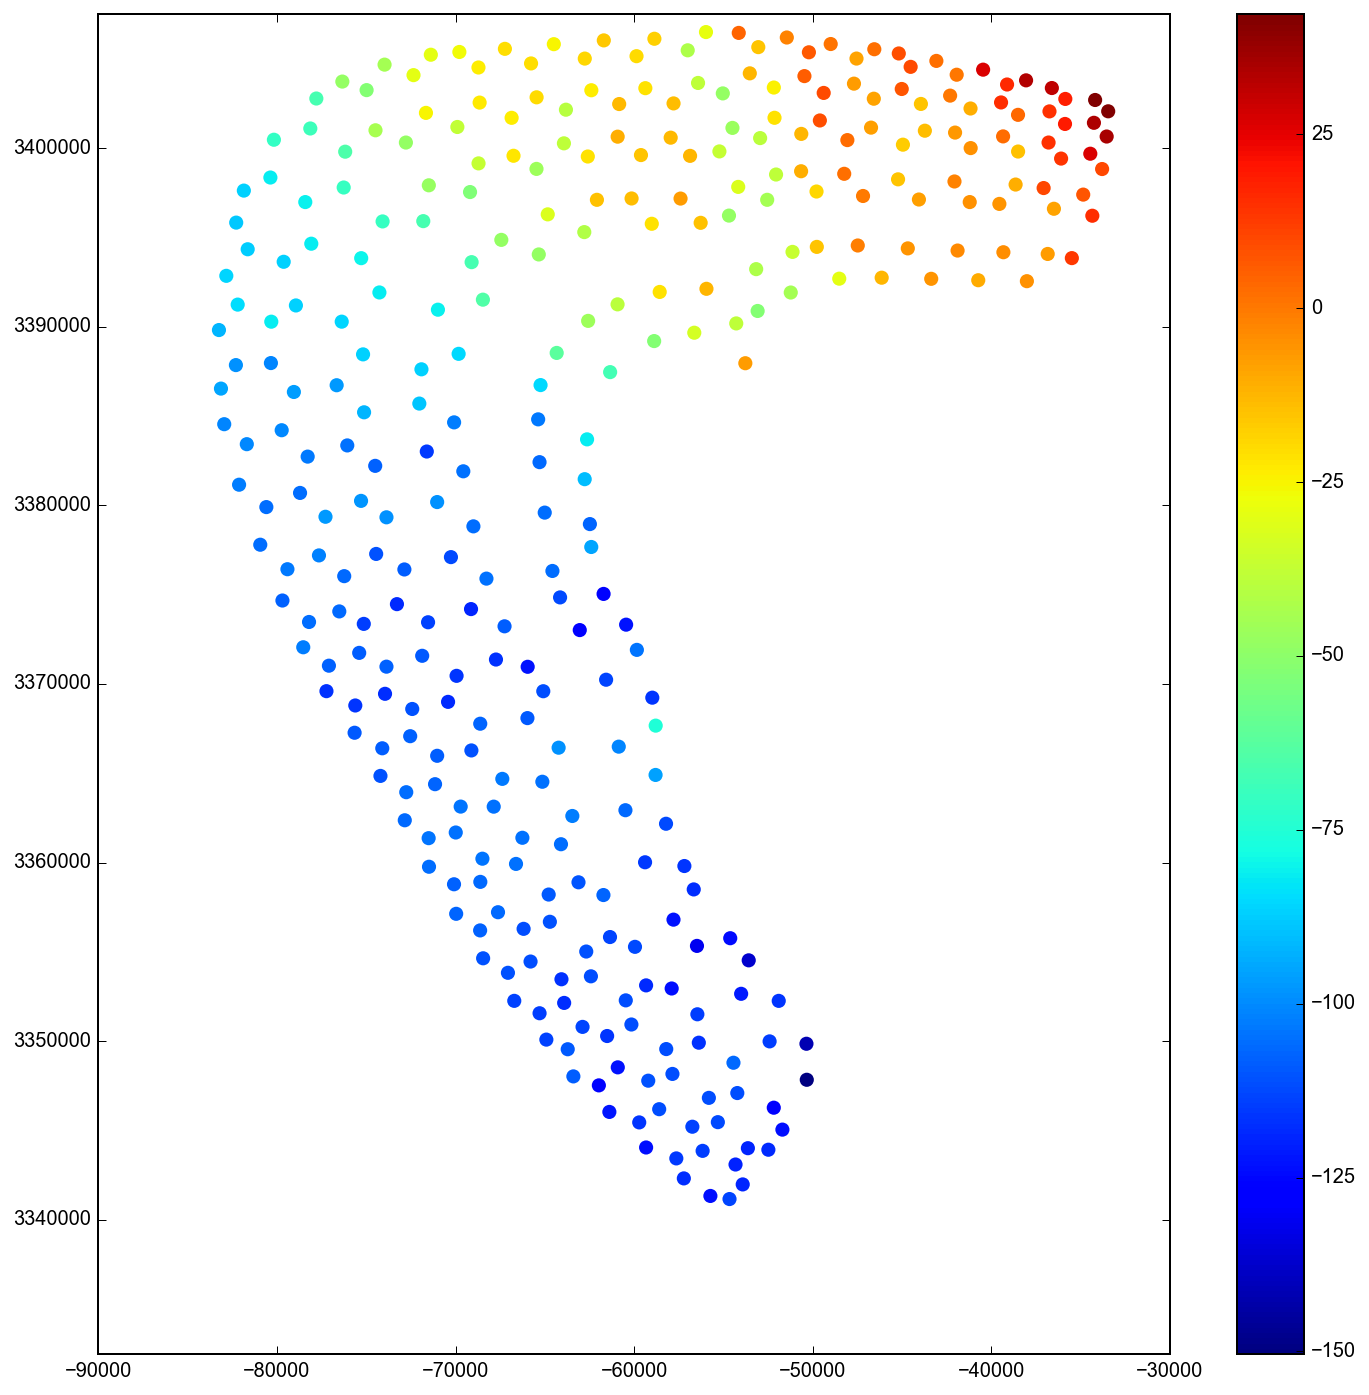

In [18]:
plt.figure(figsize=(12, 12))

plt.scatter(cx, cy, c=rakes,
           s=50, lw=0)
plt.colorbar()
plt.axis('equal')

plt.show()

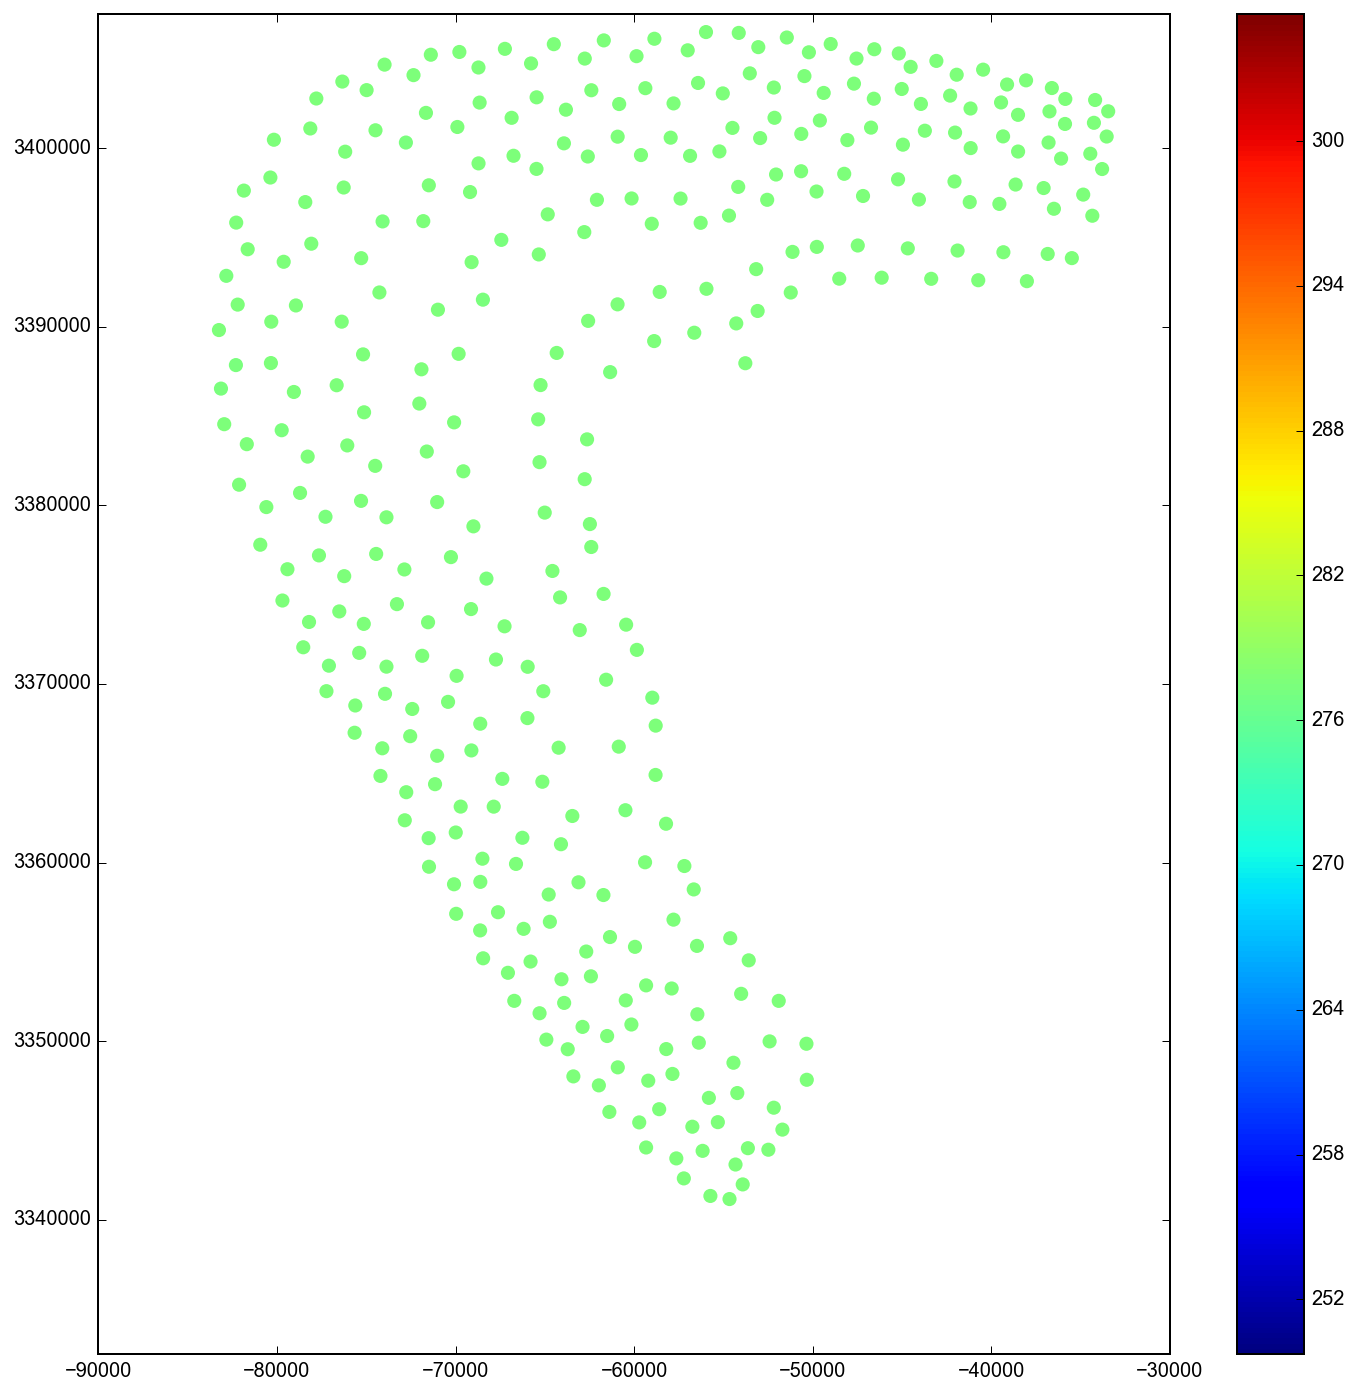

In [19]:
plt.figure(figsize=(12, 12))

plt.scatter(cx, cy, c=trends,
           s=50, lw=0)
plt.colorbar()
plt.axis('equal')

plt.show()

In [20]:
gurla_pts_df = utils.tri_dict_to_df(gc, fault_name='gurla')

In [22]:
gurla_pts_df.to_csv('../data/fault_data/gurla_pts_df.csv')

In [24]:
with open('../data/fault_data/gurla_tris.geojson', 'w') as f:
    json.dump(gc, f)